In [3]:
import setuptools  # Ensures distutils is available
import pyximport
pyximport.install()
from scipy.integrate import trapezoid as trapz
from datetime import datetime
import os
import shutil
import pandas as pd
#!/anaconda3/bin/python
from math import cos, sin, pi, sqrt
from numpy import (
    array, linspace, arange, loadtxt, vectorize, pi as npi, exp, zeros,
    empty, log, log2, finfo, true_divide, asarray, where, partition, isnan, nan,
    ones, argmax, argmin, set_printoptions, diagonal, round, inf,concatenate, sin, cos
    )
import imageio
from numpy.random import random
from scipy.integrate import trapezoid as trapz
from scipy.signal import correlate2d
from matplotlib import rcParams, rc, ticker, colors, cm
from matplotlib.style import use
from matplotlib.pyplot import subplots, close
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from os import getcwd
from datetime import datetime
import os
from matplotlib.patches import Rectangle
import matplotlib.font_manager as font_manager
import pyximport
import numpy as np
from matplotlib.ticker import ScalarFormatter, LogFormatterSciNotation
import matplotlib.colors as mcolors
from scipy.optimize import curve_fit, fsolve
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib
# Install setuptools to resolve the distutils issue
%pip install setuptools

import pyximport
pyximport.install()

from utilities import (
    calc_flux #, calc_learning_rate
    )
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})
rc('text', usetex=True)

from numpy import meshgrid
from numpy import gradient  
from scipy.interpolate import griddata
from matplotlib.colors import LinearSegmentedColormap


DEPRECATION: Loading egg at /Users/sarealles/Desktop/Data/code/.venv/lib/python3.12/site-packages/Cython-3.1.0a0-py3.12-macosx-14.0-arm64.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
def infinite_eff(psi_0,psi_1,n0,n1,model):
    '''gets the psi_0/1 that is applied to model 1,3 
    (dont divide it for mod 2,4 before hand)'''
    
    if model=="model1":
        if abs(psi_0)>abs(psi_1):
            eff = - psi_1/psi_0
        else:
            eff = - psi_0/psi_1
    if model == "model2":
        if abs(n0*psi_0/8)>abs(n1*psi_1/3):
            eff = - (n1*psi_1/3)/(n0*psi_0/8)
        elif abs(n0*psi_0/8)==abs(n1*psi_1/3):
            eff =-1
        else:
            eff = - ((n0*psi_0/8)/(n1*psi_1/3))
    if model=="model3":
        X2 = (psi_0*((n1*psi_0/n0) + psi_1))
        X1 =(psi_1*(psi_0 + (n0*psi_1/n1)))
        if X2 != 0:
            if abs(psi_0/n0)>abs(psi_1/n1):
                eff = - X1/X2
            else:
                eff = - (X1/X2)**(-1)
        else:
            eff = 0
    if model == "model4":
        psi_0 = psi_0*n0/8
        psi_1 = psi_1*n1/3
        
        X2 = (psi_0*((n1*psi_0/n0) + psi_1))
        X1 =(psi_1*(psi_0 + (n0*psi_1/n1)))
        if X2 != 0:
            if abs(psi_0/n0)>abs(psi_1/n1):
                eff = - X1/X2
            else:
                eff = - (X1/X2)**(-1)
        else:
            eff = 0
            
        # eff = ["undefined" if x == -1 else x for x in eff]
    return eff

In [5]:
def set_params(model, n0,n1,f0,f1=-2.0,E0=2.0,E1=2.0):
    N = 100
    
     # energy scale of Fo
    Ecouple = 20.0 # energy scale of coupling between Fo and F1


    psi_0 = f0
    psi_1 = f1
    psi_0_n = f0
    psi_1_n = f1
    
    if model =="model4" or model =="model2" or model=="BFM":
        psi_0_n = n0*psi_0/8
        psi_1_n = n1*psi_1/3
        

    

    m0 = 1.0
    m1 = 1.0
    beta = 1.0
    gamma = 1000.0
    phase = 0.0

    

    return (
        E0, Ecouple, E1,  psi_0, psi_1, psi_0_n, psi_1_n, 
        n0, n1,
        m0, m1, phase,beta, gamma, model
        ) 

In [6]:
import matplotlib.cm as cm

In [7]:
l_title_s = 10
l_entry_s = 8
ticks_size = 9
fs = 10
ts = 11
ms = 3
off_text_size = 9

In [34]:
def plot_P_vs_n0_and_vs_Ec_two_models(target_dir, model_array,n0_array_n0_change,Ec_curve_n0_change,Ec_array_Ec_change, n0_curve_Ec_change, n1,f0_array,f1_array,dt=0.001,N=1000,drag=1000):
    timescale = 1.5 * 10**4 
    '''timescale used in thesis'''
    timescale = 4.8 * 10**7 
    #fig for P1  vs n0 (left), P1 vs Ec (right)
    fig, ax = plt.subplots(2, 2, figsize=(9,5),sharey="row",sharex="col")
    #fig1 for P1  vs n0
    fig1, ax1 = plt.subplots(1, 2, figsize=(10,4),sharey="row")
    #fig3 for eta vs n0
    fig3, ax3 = plt.subplots(1, 2, figsize=(8,2),sharey="row")
    #fig4 for P1 vs P0
    fig4, ax4 = plt.subplots(1, 2, figsize=(10,4),sharey="row")
    # Set global tick label size
    
    ax[0,0].set_title(r"$\mathrm{constant \ force}$", fontsize=ts)
    ax[1,0].set_title(r"$\mathrm{scaling \ force}$", fontsize=ts)
    ax[0,1].set_title(r"$\mathrm{constant \ force}$", fontsize=ts)
    ax[1,1].set_title(r"$\mathrm{scaling \ force}$", fontsize=ts)
    
    ax1[0].set_title(r"$\mathrm{constant \ force}$", fontsize=ts)
    ax1[1].set_title(r"$\mathrm{scaling \ force}$", fontsize=ts)
    ax3[0].set_title(r"$\mathrm{constant \ force}$", fontsize=ts)
    ax3[1].set_title(r"$\mathrm{scaling \ force}$", fontsize=ts)
    ax4[0].set_title(r"$\mathrm{constant \ force}$", fontsize=ts)
    ax4[1].set_title(r"$\mathrm{scaling \ force}$", fontsize=ts)
    '''poster'''
    # ax[0,0].set_title(r"$\mathrm{constant \ force}$", fontsize=18)
    # ax[1,0].set_title(r"$\mathrm{scaling \ force}$", fontsize=18)
    # ax[0,1].set_title(r"$\mathrm{constant \ force}$", fontsize=18)
    # ax[1,1].set_title(r"$\mathrm{scaling \ force}$", fontsize=18)
    
    y=-1.37*(10**5)*np.ones(30)
    ax[0,0].fill_between(linspace(0,30,30),y , where=(y < 0), color='red', alpha=0.05)
    ax[1,0].fill_between(linspace(0,30,30),y , where=(y < 0), color='red', alpha=0.05)
    # y=-1.35*(10**5)*np.ones(30)
    # ax1[1].fill_between(linspace(0,30,30),y , where=(y < 0), color='red', alpha=0.1)
    # ax1[0].fill_between(linspace(0,30,30),y , where=(y < 0), color='red', alpha=0.1)
    ############################
    y=-1.37*(10**5)*np.ones(200)
    ax[0,1].fill_between(linspace(0,200,200),y , where=(y < 0), color='red', alpha=0.05)
    ax[1,1].fill_between(linspace(0,200,200),y , where=(y < 0), color='red', alpha=0.05)
    ###########################
    y=-0.65*np.ones(len(n0_array_n0_change))
    ax3[0].fill_between(n0_array_n0_change,y , where=(y < 0), color='red', alpha=0.05)
    ax3[1].fill_between(n0_array_n0_change,y , where=(y < 0), color='red', alpha=0.05)
    
    for i in range(2):
        '''P1 sepaarte'''
        ax1[i].axhline(0.0,color="black", lw=1.0)
        ax1[i].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        ax1[i].yaxis.offsetText.set_fontsize(off_text_size) 
        ax1[i].spines['right'].set_visible(False)
        ax1[i].spines['bottom'].set_visible(False)
        ax1[i].spines['top'].set_visible(False)
        ax1[i].set_xscale("log")
        ax1[i].set_xlim(left=1,right=17)
        ax1[i].set_xticks([1, 5, 10,15,20])
        ax1[i].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
        '''eta separate'''
        ax3[i].axhline(0.0, color="black", lw=1.0)
        ax3[i].spines['right'].set_visible(False)
        ax3[i].spines['bottom'].set_visible(False)
        ax3[i].spines['top'].set_visible(False)
        ax3[i].set_xscale("log")
        ax3[i].set_xlim(left=1, right=17)
        ax3[i].set_xticks([1, 2,5, 10, 20])
        ax3[i].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
        
        
        '''p vs p separate'''
        ax4[i].axhline(0.0, color="black", lw=1.0)
        ax4[i].spines['right'].set_visible(False)
        ax4[i].spines['bottom'].set_visible(False)
        ax4[i].spines['top'].set_visible(False)
        # ax4[i].set_xscale("symlog")
        ax4[i].set_yscale("symlog")
        # ax4[i].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
        # ax4[i].get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
        for j in range(2):
            ax[i,j].axhline(0.0,color="black", lw=1.0, zorder=-1000)
            ax[i,j].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
            ax[i, j].yaxis.offsetText.set_fontsize(off_text_size) 
            ax[i,j].spines['right'].set_visible(False)
            ax[i,j].spines['bottom'].set_visible(False)
            ax[i,j].spines['top'].set_visible(False)
            ax[i,j].set_xscale("log")
            ax[i,0].set_xlim(left=1,right=20)
            ax[0,j].set_xlim(left=1,right=128)
            ax[i,0].set_xticks([1, 2,5, 10,15,20])
            ax[i,j].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
            
            
    '''second column'''
    for ii,model in enumerate(model_array[2:]):
        print(ii)
        input_file_name = (
            "/" + model + "_flux_power_efficiency_"
            + "E0_{0}_E1_{1}_psi0_{2}_psi1_{3}_n0_{4}_n1_{5}_phase_{6}_outfile.dat"
            )

        colors = cm.RdPu(np.linspace(1, 0.5, len(n0_curve_Ec_change)))

        for h, (n0, color) in enumerate(zip(n0_curve_Ec_change, colors)):
            [
            E0, __,E1, psi_0, psi_1,psi_0_n, psi_1_n, __, __,
            m0, m1, phase,beta, gamma,__
            ] = set_params(model, n0, n1, f0_array[ii+2], E0=2.0, E1=2.0)
            n0n1_str = str(int(n0)) + "_" + str(int(n1))
            target = target_dir[ii+2]
            try:
                Ecouple_array, integrate_flux_X, integrate_flux_Y, integrate_power_X, integrate_power_Y, efficiency, efficiency_mod = loadtxt(
                target + n0n1_str + input_file_name.format(E0, E1, psi_0, psi_1, n0, n1, phase), unpack=True, usecols=(0, 1, 2, 3, 4, 5, 6))
            except:
                print(f"no file for {model}, n0={n0}, n1={n1}")
                continue

            ax[ii, 1].plot(
            Ecouple_array, -2 * pi * timescale*integrate_power_Y, marker="o", lw=1.0, markersize=ms-1,
            label="${0}$".format(int(n0)), color=color, zorder=-h)
    
    
    ####################################################
    '''first column'''
    Ecouple= []
    maximizing_n0 = []
    index = -1
    for jj,model in enumerate(model_array[:2]): 
        index +=1
        f0 = f0_array[jj]
        f1 = f1_array[jj]
        colors = cm.PuBuGn(np.linspace(1, 0.4, len(Ec_curve_n0_change)))
        colors1 = cm.PuBuGn(np.linspace(1, 0.4, len(Ec_curve_n0_change)))
        
        r = 1
        # fig_ec, ax_ec = plt.subplots(r, int(len(Ec_curve_n0_change)/r), figsize=(5,5))
        fig_ec, ax_ec = plt.subplots(r, int(len(Ec_curve_n0_change)/r), figsize=(7,3),sharey="row")
        fig_ec_tot, ax_ec_tot = plt.subplots(1, 1, figsize=(4, 2))
        ax_ec[0].set_ylabel(r"$\mathrm{output \ power} \ \beta \mathcal{P}_{1} \ (\rm{s}^{-1})$", fontsize=fs-5)
        # fig_ec.supylabel(r"$\mathrm{output \ power} \ \beta \mathcal{P}_{1} \ (\rm{s}^{-1})$", fontsize=fs-5)
        marker_list = ['s', 'o', 'D', 'v', '^', 'x', 'p', '*', 'h', 'H', '8', 'X']
        size_list = [70,50,30,20]
        alpha_list = [0.5, 0.6, 0.7, 0.8]
        for i,Ec in enumerate(Ec_curve_n0_change):
            n0_exists = []
            P_at_Ec = []
            P0_at_Ec = []
            eta_at_Ec = []
            eta_at_inf = []
            eta_Fo_wins = []
            j1_at_Ec = []
            jo_at_Ec = []
            jslip_at_Ec = []
            
            for n0 in n0_array_n0_change:
                params = set_params(model, n0,n1,f0,f1)
                n0n1_str = str(int(n0))+"_"+ str(int(n1))
                '''uncomment the following line and comment the lines after for model1,2'''

                target_dir_temp = target_dir[jj] + n0n1_str
                #     print(target_dir_temp)
                    
                if not os.path.exists(target_dir_temp):
                    print(target_dir_temp)
            
                [
                E0, __,E1, psi_0, psi_1,psi_0_n, psi_1_n, __, __,
                m0, m1, phase,beta, gamma,__
                ] = params

                input_file_name = ("/" + model + "_flux_power_efficiency_"
                + "E0_{0}_E1_{1}_psi0_{2}_psi1_{3}_n0_{4}_n1_{5}_phase_{6}_outfile.dat")
                
                if not os.path.exists(target_dir_temp + input_file_name.format(E0, E1, psi_0, psi_1, n0, n1, phase,dt,N)):
                    continue

                Ec_list,integrate_flux_X, integrate_flux_Y,integrate_power_X, integrate_power_Y, efficiency,efficiency_mod= loadtxt(
                target_dir_temp + input_file_name.format(E0,E1, psi_0, psi_1, n0,n1,phase,dt,N),unpack=True, usecols=(0,1,2,3,4,5,6))

                # Convert Ec_list to a list if it is a single value
                if isinstance(Ec_list, float):
                    Ec_list = [Ec_list]
                    integrate_power_Y = [integrate_power_Y]
                    integrate_power_X = [integrate_power_X]
                    integrate_flux_X = [integrate_flux_X]
                    integrate_flux_Y = [integrate_flux_Y]
                    efficiency_mod = [efficiency_mod]
                    efficiency = [efficiency]

                # print(integrate_power_Y)
                for j in range(len(Ec_list)):
                    ticks = []
                    if Ec_list[j] == Ec:
                        j1_at_Ec.append(integrate_flux_Y[j])
                        jo_at_Ec.append(integrate_flux_X[j])
                        eta_Fo_wins.append(efficiency[j])
                        n0_exists.append(int(n0))
                        P0_at_Ec.append(2*pi*integrate_power_X[j])
                        
                        
                        if model=="BFM" and f1==-0.0:
                            P_at_Ec.append(2*pi*drag*((j1_at_Ec[-1])**2))
                            # eta_at_Ec.append(P_at_Ec[-1]/P0_at_Ec[-1])
                        else:
                            P_at_Ec.append(-2*pi*integrate_power_Y[j])
                            eta_at_Ec.append(efficiency_mod[j])
                            
                        
                        if model =="model3" or model=="model4" or model=="BFM":
                            jslip_at_Ec.append(n0*integrate_flux_X[j]-n1*integrate_flux_Y[j])
                        else:
                            jslip_at_Ec.append(integrate_flux_X[j]-integrate_flux_Y[j])
                            
                        
                eta_at_inf.append(infinite_eff(psi_0,psi_1,n0,n1,model))
                
            x = timescale*array(P0_at_Ec)
            y = timescale*array(P_at_Ec)
            n = len(x)
            d = int(len(Ec_curve_n0_change)//r)
            colors_ec = [(tt / (n - 1), 0, 1 - tt / (n - 1)) for tt in range(n)]
            ########two panels##############
            # ax_ec[i//d,i%d].plot(x, y, label=fr"${int(Ec)}$", marker="o", color=colors[i], lw=1.0, markersize=2)
            # ax_ec[i//d,i%d].ticklabel_format(style='sci', axis='both', scilimits=(0, 0))
            # ax_ec[i//d,i%d].spines['right'].set_visible(False)
            # ax_ec[i//d,i%d].spines['top'].set_visible(False)
            # for t in range(0, len(x)-1, 1):
            #     ax_ec[i//d,i%d].annotate(
            #         '',
            #         xy=(x[t+1], y[t+1]),
            #         xytext=(x[t], y[t]),
            #         arrowprops=dict(arrowstyle="-", color=colors_ec[t], lw=1),
            #     )
            
            # ax_ec[i//d,i%d].set_title(fr"$\beta E_{{\rm c}} = {int(Ec)}$", fontsize=fs-8)
            ##########one panel##############
            ax_ec_tot.plot(x, y, marker=" ", lw=2.5, label=fr"${int(Ec)}$", color=colors1[i])
            n0_color=np.linspace(1, 20, len(x))
            select_n0_color = [cm.RdPu(i) for i in np.linspace(0.5, 1.0, 3)]
            def truncate_colormap(cmap, minval=0.3, maxval=1, n=256):
                """Truncate a colormap to a subrange [minval, maxval]."""
                new_colors = cmap(np.linspace(minval, maxval, n))
                return LinearSegmentedColormap.from_list(f"trunc({cmap.name})", new_colors)

            # Create a darker version of RdPu
            
            dark_RdPu = truncate_colormap(cm.get_cmap("RdPu"))
            # dark_RdPu = truncate_colormap(cm.get_cmap("tab20b"))

            # Example scatter plot with the new colormap
            print("len x is ", len(x))
            count = 0
            for k in [5,11,17]:
                ax_ec_tot.scatter(x[k], y[k], marker=marker_list[i], c=select_n0_color[count], s=size_list[i], zorder=3, edgecolors='black', linewidths=0.5)
                count += 1
            ax_ec[i%d].plot(x, y, label=fr"${int(Ec)}$", marker="o", color=colors[i], lw=1.0, markersize=2)
            ax_ec[i%d].ticklabel_format(style='sci', axis='both', scilimits=(0, 0))
            ax_ec[i%d].spines['right'].set_visible(False)
            ax_ec[i%d].spines['top'].set_visible(False)
            for t in range(0, len(x)-1, 1):
                ax_ec[i%d].annotate(
                    '',
                    xy=(x[t+1], y[t+1]),
                    xytext=(x[t], y[t]),
                    arrowprops=dict(arrowstyle="-", color=colors_ec[t], lw=1),
                )
                # ax_ec_tot.annotate(
                #     '',
                #     xy=(x[t+1], y[t+1]),
                #     xytext=(x[t], y[t]),
                #     arrowprops=dict(arrowstyle="-", color=colors_ec[t], lw=2),
                # )
            
            ax_ec[i%d].set_title(fr"$\beta E_{{\rm c}} = {int(Ec)}$", fontsize=fs-8)
            
            
            
            
            
            # ax_ec[i//d, i%d].set_yscale("symlog")
            # ax_ec[i//d, i%d].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
            # if model == "model2":
            #     tavan_max = np.ceil(np.log10(np.max(x)))
            #     if np.min(x) < 0:
            #         tavan_min = -np.ceil(np.log10(np.abs(np.min(x)))) - 1
            #     else:
            #         tavan_min = np.floor(np.log10(np.min(x)))
            #     ticks = [10**int(tavan_min + ttt) for ttt in range(0, int(tavan_max - tavan_min) + 1, 3)]
            #     print("ticks are ", ticks)
            #     ax_ec[i//d, i%d].set_xticks(ticks)
            #     ax_ec[i//d, i%d].ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
            #     ax_ec[i//d, i%d].set_xscale("symlog")
            # else:
            #     ax_ec[i//d, i%d].set_yscale("symlog")


            
            if len(n0_exists)!=0:
                Ecouple.append(Ec)
                maximizing_n0.append(n0_exists[argmax(j1_at_Ec)])
            # print(fr"at {int(Ec)}, n0 that maximizes J1 is: {n0_exists[argmax(j1_at_Ec)]}")
            '''power vs. power separate fig'''
            ax4[jj].plot(timescale*array(P0_at_Ec),timescale*array(P_at_Ec), label = fr"${int(Ec)}$",marker ="o", color=colors[i],lw=1.0,markersize=6)
            '''efficiency separate fig'''
            if model == "model1" :
                ax3[jj].scatter(n0_array_n0_change,eta_at_inf, marker="s",alpha = 0.08, s=30, color='purple')  
            if model =="model2":
                eta_at_inf[3]=np.nan                    
                ax3[jj].scatter(n0_array_n0_change,eta_at_inf, marker="s",alpha = 0.08, s=30, color='purple')  
                n0_exists_no_stall = []
                eta_at_Ec_no_stall = []
                stall_point = int(-8*f1/f0)
                print("stall point is ", stall_point)
                for ii,n0 in enumerate(n0_exists):
                    if int(n0) != stall_point:
                        eta_at_Ec_no_stall.append(eta_at_Ec[ii])
                        n0_exists_no_stall.append(n0)
                    else:
                        eta_at_Ec_no_stall.append(nan)
                        n0_exists_no_stall.append(nan)
                        
                eta_at_Ec_no_stall = array(eta_at_Ec_no_stall)
                n0_exists_no_stall = array(n0_exists_no_stall)
            elif model =="model4":
                n0_exists_no_stall = []
                eta_at_Ec_no_stall = []
                stall_point = int(-f0*n1/f1)
                for ii,n0 in enumerate(n0_exists):
                    if int(n0) != stall_point:
                        eta_at_Ec_no_stall.append(eta_at_Ec[ii])
                        n0_exists_no_stall.append(n0)
                eta_at_Ec_no_stall = array(eta_at_Ec_no_stall)
                n0_exists_no_stall = array(n0_exists_no_stall)
            else:
                n0_exists_no_stall = n0_exists
                eta_at_Ec_no_stall = eta_at_Ec
            if len(eta_at_Ec)>0:
                ax3[jj].plot(n0_exists_no_stall,eta_at_Ec_no_stall, label = fr"${int(Ec)}$",marker ="o", color=colors[i],lw=1.0,markersize=ms)
            ax3[jj].tick_params(labelsize=ticks_size, axis='both')
            ax3[jj].set_xlabel(r"$\# \ \mathrm{subunits \ on} \ \mathrm{F_{o}} \ (n_{\rm o})$", fontsize=fs)
            
            ax4[jj].tick_params(labelsize=ticks_size, axis='both')
            ax4[jj].set_xlabel(r"$\mathrm{input \ power} \ \beta \mathcal{P}_{\rm o} \ (\rm{s}^{-1})$", fontsize=fs)
            
            #################

            ax[index,0].plot(n0_exists,timescale*array(P_at_Ec), label = fr"${int(Ec)}$",marker ="o", color=colors[i],lw=1.0,markersize=ms, zorder=-i)
            ax[index,0].tick_params(labelsize=ticks_size, axis='both')
            ax[index,1].tick_params(labelsize=ticks_size, axis='both')
            ax[index,0].set_xticks(n0_exists)
            ax[index,0].set_ylabel(r"$\mathrm{output \ power} \ \beta \mathcal{P}_{1} \ (\rm{s}^{-1})$", fontsize=fs)
            
            '''separate fig'''
            ax1[jj].plot(n0_exists,timescale*array(P_at_Ec), label = fr"${int(Ec)}$",marker ="o", color=colors1[i],lw=1.0,markersize=ms)
            ax1[jj].tick_params(labelsize=ticks_size, axis='both')
            ax1[jj].tick_params(labelsize=ticks_size, axis='both')
            ax1[jj].set_xticks(n0_exists)
            ax1[0].set_ylabel(r"$\mathrm{output \ power} \ \beta \mathcal{P}_{1} \ (\rm{s}^{-1})$", fontsize=fs)
        fig_ec.tight_layout()
        fig_ec.show()
                    
    '''separate fig'''
    ax3[0].set_ylabel(r"$\mathrm{efficiency} \ \eta$", fontsize=fs)
    ax3[1].legend(prop={'size': l_entry_s}, title=r'$\beta E_{\rm c}$', title_fontsize=l_title_s, frameon=False, ncol=1, labelspacing=0.25, loc=(0.35, 0.25))
    
    ax4[0].set_ylabel(r"$\mathrm{output \ power} \ \beta \mathcal{P}_{1} \ (\rm{s}^{-1})$", fontsize=fs)
    ax4[0].legend(prop={'size': l_entry_s}, title=r'$\beta E_{\rm c}$', title_fontsize=l_title_s, frameon=False, ncol=1, labelspacing=0.3, loc='best')

    
    ax1[1].set_xlabel(r"$\# \ \mathrm{subunits \ on} \ \mathrm{F_{o}} \ (n_{\rm o})$", fontsize=fs)
    ax1[0].set_xlabel(r"$\# \ \mathrm{subunits \ on} \ \mathrm{F_{o}} \ (n_{\rm o})$", fontsize=fs)
    ax1[1].set_xticks(n0_exists)
    ax1[1].set_xticks([1,3,10,20])
    ax1[0].set_xticks(n0_exists)
    ax1[0].set_xticks([1,3,10,20])
    ax1[1].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax1[0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax1[0].legend(prop={'size': l_entry_s}, title=r'$\beta E_{\rm c}$', title_fontsize=l_title_s, frameon=False, ncol=1, labelspacing=0.3, loc='best')

    ax_ec_tot.hlines(0.0, xmin=min(x),xmax=max(x)+1000,color="black", linestyle="solid",lw=0.5,zorder=-100)
    ax_ec_tot.set_xlabel(r"$\mathrm{input \ power} \ \beta \mathcal{P}_{\rm o} \ (\rm{s}^{-1})$", fontsize=fs)
    ax_ec_tot.set_ylabel(r"$\mathrm{output \ power} \ \beta \mathcal{P}_{1} \ (\rm{s}^{-1})$", fontsize=fs)
    ax_ec_tot.tick_params(labelsize=ticks_size, axis='both')
    # ax_ec_tot.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(prune='lower'))
    ax_ec_tot.spines['left'].set_position(('data', 0))
    ax_ec_tot.spines['left'].set_visible(True)
    ax_ec_tot.yaxis.set_ticks_position('left')
    ax_ec_tot.yaxis.set_label_position('left')
    # ax_ec_tot.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(prune='upper'))
    # ax_ec_tot.set_xscale("symlog")
    # ax_ec_tot.set_yscale("symlog")
    # cbar = fig_ec_tot.colorbar(ax_ec_tot.collections[0], ax=ax_ec_tot, orientation='horizontal', pad=0.2, aspect=50)
    # cbar.set_label(r'$n_{\rm o}$', fontsize=fs)
    # cbar.ax.tick_params(labelsize=fs - 7)  # Adjust tick label size
    # cbar.set_ticks([1,5,10,15,20])  # Set the lowest tick to 1 and the highest tick to 20

    ax_ec_tot.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax_ec_tot.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax_ec_tot.spines['right'].set_visible(False)
    ax_ec_tot.spines['top'].set_visible(False)
    
    # ax_ec_tot.set_xscale("symlog")
    ax_ec_tot.ticklabel_format(style='sci', axis='both', scilimits=(0, 0))
    ax_ec_tot.spines['left'].set_alpha(0.7)
    ax_ec_tot.spines['bottom'].set_alpha(0.7)
    ax_ec_tot.spines['left'].set_zorder(-1000)
    ax_ec_tot.spines['bottom'].set_zorder(-1000)
    ax_ec_tot.set_yticks([0, 1e5, 2e5])
    ax_ec_tot.set_xticks([0, 1e6, 2e6])
    ax_ec_tot.set_xlim(right=2.5e6)
    ax_ec_tot.xaxis.offsetText.set_fontsize(off_text_size)
    ax_ec_tot.yaxis.offsetText.set_fontsize(off_text_size)
    ax_ec_tot.legend(prop={'size': l_entry_s}, title=r'$\beta E_{\rm c}$', title_fontsize=l_title_s, frameon=False, ncol=1, labelspacing=0.3, loc='best')


    ax[0,0].vlines(x=3, ymin=-1.37*(10**5), ymax=0.9*(10**5), color='black', linestyle='solid', lw=0.5, zorder=-100)
    ax[1,0].vlines(x=3, ymin=-1.37*(10**5), ymax=2.1*(10**5), color='black', linestyle='solid', lw=0.5, zorder=-100)

    ax[1,0].set_xlabel(r"$\# \ \mathrm{subunits \ on} \ \mathrm{F_{o}} \ (n_{\rm o})$", fontsize=fs)
    ax[1,1].set_xlabel(r"$\beta E_{\rm c}$", fontsize=fs)
    ax[1,0].set_xticks(n0_exists)
    ax[1,0].set_xticks([1,2,5,10,20])
    ax[0,0].set_ylim(top=1*(10**5))
    ax[1,0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax[1,0].legend(prop={'size': l_entry_s}, title=r'$\beta E_{\rm c}$', title_fontsize=l_title_s, frameon=False, ncol=1, labelspacing=0.2, loc=(0.04, 0.38))
    ax[1,1].legend(prop={'size': l_entry_s}, title=r'$n_{\rm o}$', title_fontsize=l_title_s, frameon=False, ncol=1, labelspacing=0.2, loc=(0.05, 0.38))
    
    # ax[0,0].tick_params(axis='x', labelsize=ticks_size)
    # ax[1,0].tick_params(axis='y', labelsize=ticks_size)
    # ax[0,1].tick_params(axis='x', labelsize=ticks_size)
    # ax[1,1].tick_params(axis='y', labelsize=ticks_size)
    # ax[1,0].set_xlim(0, 14.9)
            
    # Save first row
    #######################
    
    # ax3[1].fill_between(n0_array,y , where=(y < 0), color='red', alpha=0.2)
    #####################
    # fig.savefig(fr"/Users/sarealles/Desktop/research/Paper/model1_2_P1_vs_n0_vs_Ec_n1_{n1}_fo_4.pdf",bbox_inches='tight')
    # fig3.savefig(fr"/Users/sarealles/Desktop/research/Paper/model1_2_eta_vs_n0_n1_{n1}_fo_4.pdf",bbox_inches='tight')
    # fig_ec.savefig(fr"/Users/sarealles/Desktop/research/Paper/model2_P1_vs_P0_n1_3_fo_4.pdf",bbox_inches='tight')
    fig_ec_tot.savefig(fr"/Users/sarealles/Desktop/research/Paper/model2_P1_vs_P0_tot_mod_n1_3_fo_4.pdf",bbox_inches='tight')

    # fig1.savefig(fr"/Users/sarealles/Desktop/research/BSC2025/model1_2_P1_vs_n0_n1_{n1}_fo_4.pdf",bbox_inches='tight')
    plt.show()

0
1
len x is  20
len x is  20
len x is  20
len x is  20


/var/folders/9p/vl2cbtm92dv2z3ypp768dkvc0000gn/T/ipykernel_36009/2940556996.py:111: UserWarning: loadtxt: input contained no data: "/Users/sarealles/Desktop/Data/Data_processed/pfe/6_3/model1_flux_power_efficiency_E0_2.0_E1_2.0_psi0_4.0_psi1_-2.0_n0_6.0_n1_3.0_phase_0.0_outfile.dat"
  Ecouple_array, integrate_flux_X, integrate_flux_Y, integrate_power_X, integrate_power_Y, efficiency, efficiency_mod = loadtxt(
/var/folders/9p/vl2cbtm92dv2z3ypp768dkvc0000gn/T/ipykernel_36009/2940556996.py:246: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  dark_RdPu = truncate_colormap(cm.get_cmap("RdPu"))
/var/folders/9p/vl2cbtm92dv2z3ypp768dkvc0000gn/T/ipykernel_36009/2940556996.py:253: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in cas

len x is  19
stall point is  4
len x is  19
stall point is  4
len x is  19
stall point is  4
len x is  19
stall point is  4


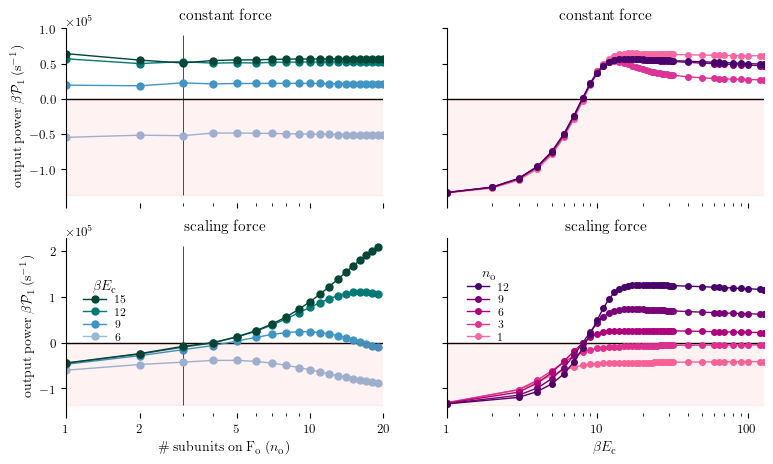

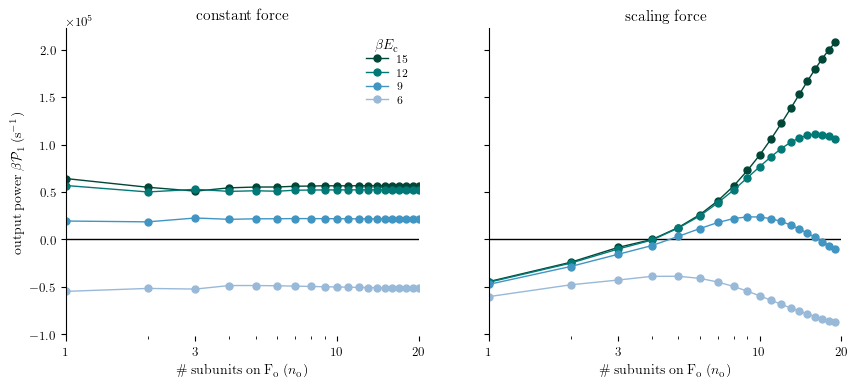

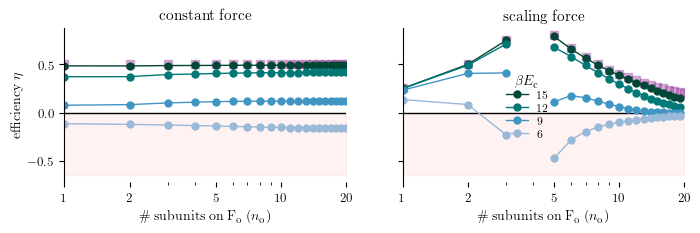

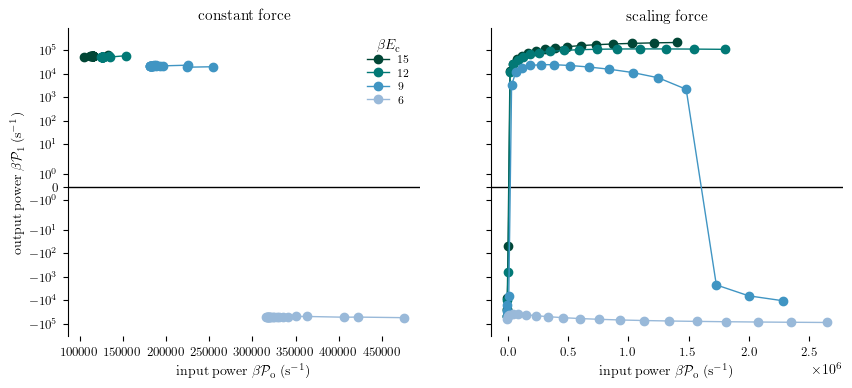

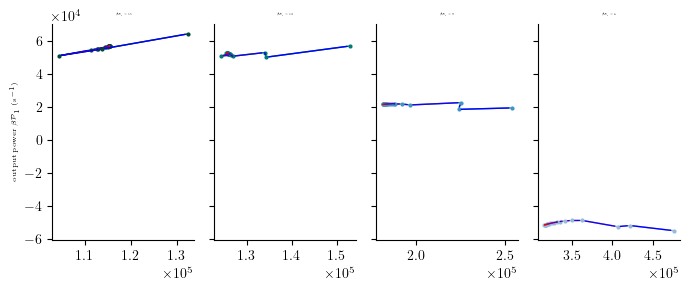

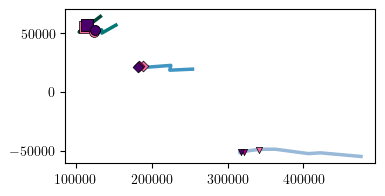

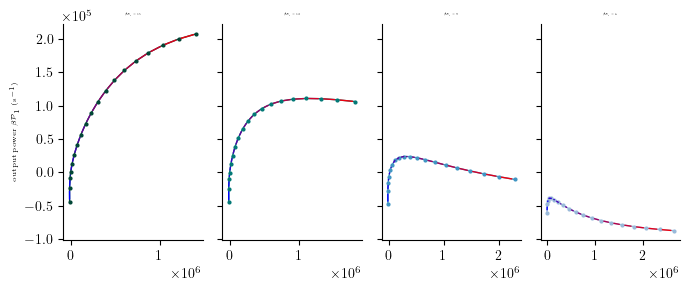

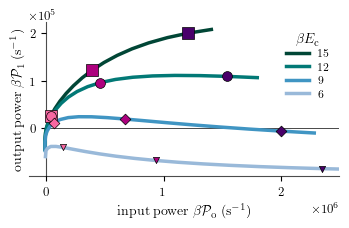

In [35]:
#########first column#######
'''for n1=3 model 1and model 2 use the following'''


target_dir_0 = "/Users/sarealles/Desktop/model1/new_data_540_CM/f0_8/pfe/"
target_dir_0_0 = "/Users/sarealles/Desktop/model1/data_N_1000/pfe/"
target_dir_1_0 = "/Users/sarealles/Desktop/model2/new_data_540_CM/E0_2/f0_4/pfe/"
# 
target_dir_0_0 = "/Users/sarealles/Desktop/Data/Data_processed/pfe_old/"
target_dir_1_0 = "/Users/sarealles/Desktop/Data/Data_processed/pfe_old/"

n0_array_n0_change = [1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0]
n0_array_n0_change = [1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0]
Ec_curve_n0_change = [128.0, 18.0, 9.0, 7.0, 4.0]
# Ec_curve_n0_change = [15.0, 10.0, 5.0]
Ec_curve_n0_change = [15.0, 12.0, 9.0, 6.0]
#########second column#######
target_dir_0_1 = "/Users/sarealles/Desktop/Data/Data_processed/pfe/"
target_dir_1_1 = "/Users/sarealles/Desktop/Data/Data_processed/pfe_old/"
n0_curve_Ec_change = [12.0,9.0,6.0,3.0,1.0]
Ec_array_Ec_change = [1.0,2.0,3.0,6.0,9.0,12.0]
'''first two values for the first column'''
target_dir = [target_dir_0_0,target_dir_1_0, target_dir_0_1,target_dir_1_1]
n1 = 3.0
f0_array = [4.0,4.0,4.0,4.0]
f1_array = [-2.0,-2.0,-2.0,-2.0]
model_array = ["model1","model2","model1","model2"]
########################
#######################
'''for n1=3, model 4 and BFM, psi0=8'''
# target_dir_0 = "/Users/sarealles/Desktop/model4/new/pfe/"
# # target_dir_0 = "/Users/sarealles/Desktop/BFM/change_gamma/pfe/"
# target_dir_1 = "/Users/sarealles/Desktop/BFM/change_gamma_f1_0/pfe/"
# target_dir = [target_dir_0,target_dir_1]
# f0_array = [8.0,8.0]
# f1_array = [-2.0,-0.0]
# model_array = ["model4","BFM"]
###################
'''for n1=3, model 4 and model 4 psi0=4,8'''
# target_dir_1 = "/Users/sarealles/Desktop/model4/new/pfe/"
# target_dir_0 = "/Users/sarealles/Desktop/Data/"
# # target_dir_1 = "/Users/sarealles/Desktop/BFM/change_gamma_f1_0/pfe/"
# target_dir = [target_dir_0,target_dir_1]
# f0_array = [4.0,8.0]
# f1_array = [-2.0,-2.0]
# model_array = ["model4","model4"]
###################
'''for n1=3, model 3 and model4, psi0=4'''
# target_dir_0 = "/Users/sarealles/Desktop/model3/pfe/"
# target_dir_1 = "/Users/sarealles/Desktop/model4/new/pfe/"

# # target_dir = [target_dir_0,target_dir_1]
# # f0_array = [8.0,8.0]
# # f1_array = [-2.0,-2.0]
# # model_array = ["model3","model4"]
# target_dir = [target_dir_0,target_dir_1, target_dir_0,target_dir_1]
# n1 = 3.0
# f0_array = [8.0,8.0,8.0,8.0]
# f1_array = [-2.0,-2.0,-2.0,-2.0]
# model_array = ["model3","model4","model3","model4"]
#########################



'''change the params in the function'''
plot_P_vs_n0_and_vs_Ec_two_models(target_dir, model_array,n0_array_n0_change,Ec_curve_n0_change,Ec_array_Ec_change, n0_curve_Ec_change, n1,f0_array,f1_array,dt=0.001,N=1000,drag=1000)

plt.show()  


in P1 vs n0, When does n0=n1 go from being a local(or sometimes global) maximum to being a minimum?

In [10]:
def symmetry_match_shift(target_dir, model,n0_array, Ec_array, n1_array,f0,f1,dt=0.001,N=1000,drag=1000):
    timescale = 1.5 * 10**4 
    '''timescale used in thesis'''
    timescale = 4.8 * 10**7 

    fs=20
    ms = [15,10,5,2]
    alpha_list = [0.5,0.8]
    colors_list = ["pink", "purple", "blue","green"]
    fig, ax = plt.subplots(1, 1, figsize=(4,4))
    ax.hlines(0.0,xmin=0, xmax=128,color="black", lw=1.0)
    ax.set_ylim(-1.5, 1.5)
    ticklist = [10,13,20,30,40,50, 60,70,80,90,100]

    


    for i,n1 in enumerate(n1_array):
        n0_max = []
        Ec_exist = []
        for Ec in Ec_array:
            All_three_exist = []
            # print(Ec)
            input_file_name = (
                "/" + model + "_flux_power_efficiency_"
                + "E0_{0}_E1_{1}_psi0_{2}_psi1_{3}_n0_{4}_n1_{5}_phase_{6}_outfile.dat"
                )

            n0_list=n0_array[i]
            P_list = []
            for n0 in n0_list:
                passage = True
                [
                E0, __,E1, psi_0, psi_1,psi_0_n, psi_1_n, __, __,
                m0, m1, phase,beta, gamma,__
                ] = set_params(model, n0, n1, f0, E0=2.0, E1=2.0)
                n0n1_str = str(int(n0)) + "_" + str(int(n1))
                try:
                    Ecouple_array, integrate_flux_X, integrate_flux_Y, integrate_power_X, integrate_power_Y, efficiency, efficiency_mod = loadtxt(
                    target_dir[i] + n0n1_str + input_file_name.format(E0, E1, psi_0, psi_1, n0, n1, phase), unpack=True, usecols=(0, 1, 2, 3, 4, 5, 6))
                except:
                    print(f"no file for {model}, n0={n0}, n1={n1}")
                    passage = False
                    continue

                if Ec in Ecouple_array:
                    All_three_exist.append(True)
                    index = where(Ecouple_array == Ec)[0][0]
                    P_list.append(integrate_flux_Y[index])
                else:
                    P_list.append("none")
            # print("P_list",P_list)
            if len(All_three_exist) == 3:
                Ec_exist.append(Ec)    
            if "none" not in P_list and len(P_list) > 0:
                print(n0_list[argmax(P_list)] , n1)
                if n0_list[argmax(P_list)] == n1:
                    print("right")
                    n0_max.append(1.0)
                else:
                    n0_max.append(-1.0)

        
        print("Ec exist",Ec_exist)
        print("n0 max",n0_max)
        ax.plot(
        Ec_exist, n0_max, marker="o", linestyle = "",lw=1.0, markersize= ms[i], color= colors_list[i],
        label="${0}$".format(int(n1))
        )
        if -1 in n0_max:
            first_negative_index = n0_max.index(-1) -1
            ax.vlines(Ec_exist[first_negative_index], -1.5, 1.5, color=colors_list[i], lw=1.0, linestyle="--")
            
            
    ticklist = sorted(ticklist)
    ax.set_xticks(ticklist)
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_yticks([])
    ax.set_xlim(left=10, right=60)
    ax.set_xlabel(r"$\beta E_{\rm c}$", fontsize=fs-5)
    ax.spines['bottom'].set_position(('data', 0))
    ax.legend(prop={'size': 13}, title=r'$n_{\rm o} = n_1$', title_fontsize=15, frameon=False, ncol=1, labelspacing=0.3, loc='best')
    fig.savefig(fr"/Users/sarealles/Desktop/research/Jun25/mod1_symmetry_match_max_to_min.pdf",bbox_inches='tight')



In [15]:
l_title_s = 10
l_entry_s = 8
ticks_size = 9
fs = 10
ts = 11
ms = 5
off_text_size = 9

In [17]:
def plot_P_vs_f0_vs_n0(target_dir, f0_array_mod1,f0_fixed_mod2,n0_fixed_mod1,n0_array_mod2,Ec_array, n1,f1_array,dt=0.001,N=1000,drag=1000):
    timescale = 1.5 * 10**4 
    '''timescale used in thesis'''
    timescale = 4.8 * 10**7 

    #fig1 for P1  vs n0
    fig1, ax1 = plt.subplots(1, 2, figsize=(4,2),sharey="row")
    #fig1 for P1  vs n0, both models in one plot
    fig2, ax2 = plt.subplots(1, 1, figsize=(4,2),sharey="row")


    
    ax1[0].set_title(r"$\mathrm{constant \ force}$", fontsize=ts)
    ax1[1].set_title(r"$\mathrm{scaling \ force}$", fontsize=ts)

    y=-0.5*(10**5)*np.ones(30)
    ax1[1].fill_between(linspace(0,30,30),y , where=(y < 0), color='red', alpha=0.1)
    ax1[0].fill_between(linspace(0,30,30),y , where=(y < 0), color='red', alpha=0.1)
    
    y=-0.4*(10**5)*np.ones(30)
    ax2.fill_between(linspace(0,30,30),y , where=(y < 0), color='red', alpha=0.1)
    ############################

    
    for i in range(2):
        '''P1 separate'''
        ax1[i].axhline(0.0,color="black", lw=1.0)
        ax1[i].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        ax1[i].yaxis.offsetText.set_fontsize(off_text_size) 
        ax1[i].spines['right'].set_visible(False)
        ax1[i].spines['bottom'].set_visible(False)
        ax1[i].spines['top'].set_visible(False)
        ax1[i].set_xscale("log")
        ax1[i].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
        ax1[i].xaxis.set_minor_locator(matplotlib.ticker.NullLocator())
        
    ax2.axhline(0.0, color="black", lw=1.0)
    ax2.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    ax2.yaxis.offsetText.set_fontsize(off_text_size)
    ax2.spines['right'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.set_xscale("log")
    ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax2.xaxis.set_minor_locator(matplotlib.ticker.NullLocator())
            
            
    colors = cm.PuBuGn(np.linspace(0.4, 1, len(Ec_array)))
    colors1 = cm.gist_earth(np.linspace(0.1, 0.6, len(Ec_array)))[::-1]
    colors1 = ["green","mediumseagreen","yellowgreen"]
    Ecouple= []
    maximizing_n0 = []
    ############################
    model = "model1"
    f1 = f1_array[0]
    for i,Ec in enumerate(Ec_array):
        f0_exists = []
        P_at_Ec = []
        P0_at_Ec = []
        eta_at_Ec = []
        eta_at_inf = []
        eta_Fo_wins = []
        j1_at_Ec = []
        jo_at_Ec = []
        jslip_at_Ec = []
        
        for f0 in f0_array_mod1:
            params = set_params(model, n0_fixed_mod1,n1,f0,f1)
            n0n1_str = str(int(n0_fixed_mod1))+"_"+ str(int(n1))
            '''uncomment the following line and comment the lines after for model1,2'''

            target_dir_temp = target_dir[0] + n0n1_str
            #     print(target_dir_temp)
                
            if not os.path.exists(target_dir_temp):
                print(target_dir_temp)
        
            [
            E0, __,E1, psi_0, psi_1,psi_0_n, psi_1_n, __, __,
            m0, m1, phase,beta, gamma,__
            ] = params

            input_file_name = ("/" + model + "_flux_power_efficiency_"
            + "E0_{0}_E1_{1}_psi0_{2}_psi1_{3}_n0_{4}_n1_{5}_phase_{6}_outfile.dat")
            
            if not os.path.exists(target_dir_temp + input_file_name.format(E0, E1, psi_0, psi_1, n0_fixed_mod1, n1, phase,dt,N)):
                continue

            Ec_list,integrate_flux_X, integrate_flux_Y,integrate_power_X, integrate_power_Y, efficiency,efficiency_mod= loadtxt(
            target_dir_temp + input_file_name.format(E0,E1, psi_0, psi_1, n0_fixed_mod1,n1,phase,dt,N),unpack=True, usecols=(0,1,2,3,4,5,6))

            # Convert Ec_list to a list if it is a single value
            if isinstance(Ec_list, float):
                Ec_list = [Ec_list]
                integrate_power_Y = [integrate_power_Y]
                integrate_power_X = [integrate_power_X]
                integrate_flux_X = [integrate_flux_X]
                integrate_flux_Y = [integrate_flux_Y]
                efficiency_mod = [efficiency_mod]
                efficiency = [efficiency]

            # print(integrate_power_Y)
            for j in range(len(Ec_list)):
                if Ec_list[j] == Ec:
                    print("Ec match at", Ec)
                    j1_at_Ec.append(integrate_flux_Y[j])
                    jo_at_Ec.append(integrate_flux_X[j])
                    eta_Fo_wins.append(efficiency[j])
                    f0_exists.append(f0)
                    P0_at_Ec.append(2*pi*integrate_power_X[j])
                    
                    
                    if model=="BFM" and f1==-0.0:
                        P_at_Ec.append(2*pi*drag*((j1_at_Ec[-1])**2))
                        # eta_at_Ec.append(P_at_Ec[-1]/P0_at_Ec[-1])
                    else:
                        P_at_Ec.append(-2*pi*integrate_power_Y[j])
                        eta_at_Ec.append(efficiency_mod[j])
                        
                    
                    if model =="model3" or model=="model4" or model=="BFM":
                        jslip_at_Ec.append(n0*integrate_flux_X[j]-n1*integrate_flux_Y[j])
                    else:
                        jslip_at_Ec.append(integrate_flux_X[j]-integrate_flux_Y[j])
                else:
                    print(f"Ec not match at Ec = {Ec_list[j]}, f0 = {f0}, psi0= {psi_0},n0 = {n0_fixed_mod1}, n1 = {n1}")
                        
                    
            eta_at_inf.append(infinite_eff(psi_0,psi_1,n0_fixed_mod1,n1,model))
        print("fo list", f0_exists)
        if len(f0_exists)!=0:
            Ecouple.append(Ec)
            maximizing_n0.append(f0_exists[argmax(j1_at_Ec)])
        '''separate fig'''
        
        ax1[0].plot(f0_exists,timescale*array(P_at_Ec), label = fr"${int(Ec)}$",marker ="o", color=colors1[i],lw=1.0,markersize=ms )
        ax1[0].tick_params(labelsize= fs, axis='both')
        ax1[0].tick_params(labelsize= fs, axis='both')
        # ax1[0].set_xticks(f0_exists)
        ax1[0].set_ylabel(r"$\mathrm{output \ power} \ \beta \mathcal{P}_{1} \ (\rm{s}^{-1})$", fontsize=fs)
        
        
        ax2.plot(f0_exists, timescale * array(P_at_Ec), label=fr"${int(Ec)}$", marker="o", color=colors1[i], ls="solid",lw=1.0, markersize=ms+2)
        ax2.tick_params(labelsize= fs, axis='both')
        ax2.tick_params(labelsize= fs, axis='both')
        # ax1[0].set_xticks(f0_exists)
        ax2.set_ylabel(r"$\mathrm{output \ power} \ \beta \mathcal{P}_{1} \ (\rm{s}^{-1})$", fontsize=fs+2)
    ####################################################################################################
    Ecouple= []
    maximizing_n0 = []
    model = "model2"
    f1 = f1_array[1]
    ax2.legend(prop={'size': l_entry_s}, title=r'$\beta E_{\rm c}$', title_fontsize=l_title_s, frameon=False, ncol=1, labelspacing=1, loc='best')

    for i,Ec in enumerate(Ec_array):
        n0_exists = []
        P_at_Ec = []
        P0_at_Ec = []
        eta_at_Ec = []
        eta_at_inf = []
        eta_Fo_wins = []
        j1_at_Ec = []
        jo_at_Ec = []
        jslip_at_Ec = []
        
        for n0 in n0_array_mod2:
            params = set_params(model, n0,n1,f0_fixed_mod2,f1)
            n0n1_str = str(int(n0))+"_"+ str(int(n1))
            '''uncomment the following line and comment the lines after for model1,2'''

            target_dir_temp = target_dir[1] + n0n1_str
            #     print(target_dir_temp)
                
            if not os.path.exists(target_dir_temp):
                print(target_dir_temp)
        
            [
            E0, __,E1, psi_0, psi_1,psi_0_n, psi_1_n, __, __,
            m0, m1, phase,beta, gamma,__
            ] = params

            input_file_name = ("/" + model + "_flux_power_efficiency_"
            + "E0_{0}_E1_{1}_psi0_{2}_psi1_{3}_n0_{4}_n1_{5}_phase_{6}_outfile.dat")
            
            if not os.path.exists(target_dir_temp + input_file_name.format(E0, E1, psi_0, psi_1, n0, n1, phase,dt,N)):
                continue

            Ec_list,integrate_flux_X, integrate_flux_Y,integrate_power_X, integrate_power_Y, efficiency,efficiency_mod= loadtxt(
            target_dir_temp + input_file_name.format(E0,E1, psi_0, psi_1, n0,n1,phase,dt,N),unpack=True, usecols=(0,1,2,3,4,5,6))

            # Convert Ec_list to a list if it is a single value
            if isinstance(Ec_list, float):
                Ec_list = [Ec_list]
                integrate_power_Y = [integrate_power_Y]
                integrate_power_X = [integrate_power_X]
                integrate_flux_X = [integrate_flux_X]
                integrate_flux_Y = [integrate_flux_Y]
                efficiency_mod = [efficiency_mod]
                efficiency = [efficiency]

            # print(integrate_power_Y)
            for j in range(len(Ec_list)):
                if Ec_list[j] == Ec:
                    j1_at_Ec.append(integrate_flux_Y[j])
                    jo_at_Ec.append(integrate_flux_X[j])
                    eta_Fo_wins.append(efficiency[j])
                    n0_exists.append(int(n0))
                    P0_at_Ec.append(2*pi*integrate_power_X[j])
                    
                    
                    if model=="BFM" and f1==-0.0:
                        P_at_Ec.append(2*pi*drag*((j1_at_Ec[-1])**2))
                        # eta_at_Ec.append(P_at_Ec[-1]/P0_at_Ec[-1])
                    else:
                        P_at_Ec.append(-2*pi*integrate_power_Y[j])
                        eta_at_Ec.append(efficiency_mod[j])
                        
                    
                    if model =="model3" or model=="model4" or model=="BFM":
                        jslip_at_Ec.append(n0*integrate_flux_X[j]-n1*integrate_flux_Y[j])
                    else:
                        jslip_at_Ec.append(integrate_flux_X[j]-integrate_flux_Y[j])
                        
                    
            eta_at_inf.append(infinite_eff(psi_0,psi_1,n0,n1,model))

        if len(n0_exists)!=0:
            Ecouple.append(Ec)
            maximizing_n0.append(n0_exists[argmax(j1_at_Ec)])
        '''separate fig'''
        ax1[1].plot(array(n0_exists)*(f0_fixed_mod2/8),timescale*array(P_at_Ec), label = fr"${int(Ec)}$",marker ="s", color=colors1[i],lw=1.0,markersize=ms )
        ax1[1].tick_params(labelsize=fs, axis='both')
        ax1[1].tick_params(labelsize=fs, axis='both')
        ax1[1].set_xticks(n0_exists)
        # ax1[1].set_ylabel(r"$\mathrm{output \ power} \ \beta \mathcal{P}_{1} \ (\rm{s}^{-1})$", fontsize=fs)
        ax2.plot(array(n0_exists)*(f0_fixed_mod2/8), timescale*array(P_at_Ec), label=fr"${int(Ec)}$", marker="o", color=colors1[i], lw=1.0,ls="dashed", markersize=ms, markeredgecolor='black')
        ax2.tick_params(labelsize=fs, axis='both')
        ax2.tick_params(labelsize=fs, axis='both')
        ax2.set_xticks(n0_exists)
    ####################################################################################################

    ax1[1].set_xlabel(r"$n_{\rm o} \times \beta\mu_{\rm o}^{\rm sub}$", fontsize=fs)
    ax1[0].set_xlabel(r"$\beta\mu_{\rm o}^{2\pi}$", fontsize=fs)
    ax2.set_xticks([1,2,4,8])
    # ax1[1].set_xticks(n0_exists)
    ax1[1].set_xticks([1,2,4,8])
    # ax1[0].set_xticks(f0_exists)
    ax1[0].set_xticks([1,2,4,8])
    ax1[1].set_xlim(left=1, right=8.8)
    ax1[0].set_xlim(left=1, right=8.8)
    ax2.set_xlim(left=1, right=8)
    ax1[1].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax1[0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax1[0].legend(prop={'size': l_entry_s}, title=r'$\beta E_{\rm c}$', title_fontsize=l_title_s, frameon=False, ncol=1, labelspacing=0.3, loc='best')

    ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax2.set_xlabel(r"$\mathrm{driving \ force \ on} \ \rm{F}_{\rm o} \ (\beta\mu_{\rm o})$", fontsize=fs+2)

    
    # ax3[1].fill_between(n0_array,y , where=(y < 0), color='red', alpha=0.2)
    #####################
    # fig.savefig(fr"/Users/sarealles/Desktop/research/Paper/model1_2_P1_vs_n0_vs_Ec_n1_{n1}_fo_4.pdf",bbox_inches='tight')
    # fig3.savefig(fr"/Users/sarealles/Desktop/research/Paper/model1_2_eta_vs_n0_n1_{n1}_fo_4.pdf",bbox_inches='tight')

    # fig1.savefig(fr"/Users/sarealles/Desktop/research/Paper/model1_2_P1_vs_f0.pdf",bbox_inches='tight')
    fig2.savefig(fr"/Users/sarealles/Desktop/research/Paper/model1_2_P1_vs_f0_both_on_one.pdf",bbox_inches='tight')

    plt.show()

Ec not match at Ec = 7.5, f0 = 1.0, psi0= 1.0,n0 = 8.0, n1 = 3.0
Ec not match at Ec = 8.0, f0 = 1.0, psi0= 1.0,n0 = 8.0, n1 = 3.0
Ec not match at Ec = 8.5, f0 = 1.0, psi0= 1.0,n0 = 8.0, n1 = 3.0
Ec not match at Ec = 9.0, f0 = 1.0, psi0= 1.0,n0 = 8.0, n1 = 3.0
Ec not match at Ec = 9.5, f0 = 1.0, psi0= 1.0,n0 = 8.0, n1 = 3.0
Ec not match at Ec = 10.0, f0 = 1.0, psi0= 1.0,n0 = 8.0, n1 = 3.0
Ec not match at Ec = 10.5, f0 = 1.0, psi0= 1.0,n0 = 8.0, n1 = 3.0
Ec not match at Ec = 11.0, f0 = 1.0, psi0= 1.0,n0 = 8.0, n1 = 3.0
Ec not match at Ec = 11.5, f0 = 1.0, psi0= 1.0,n0 = 8.0, n1 = 3.0
Ec match at 12
Ec not match at Ec = 12.5, f0 = 1.0, psi0= 1.0,n0 = 8.0, n1 = 3.0
Ec not match at Ec = 13.0, f0 = 1.0, psi0= 1.0,n0 = 8.0, n1 = 3.0
Ec not match at Ec = 13.5, f0 = 1.0, psi0= 1.0,n0 = 8.0, n1 = 3.0
Ec not match at Ec = 14.0, f0 = 1.0, psi0= 1.0,n0 = 8.0, n1 = 3.0
Ec not match at Ec = 14.5, f0 = 1.0, psi0= 1.0,n0 = 8.0, n1 = 3.0
Ec not match at Ec = 15.0, f0 = 1.0, psi0= 1.0,n0 = 8.0, n1 = 3.0


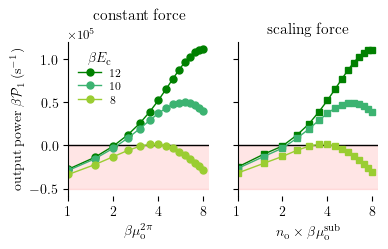

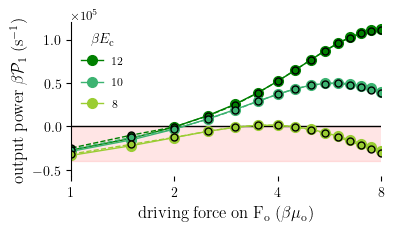

In [18]:
n1 = 3.0
Ec_array = [12,10,8]
f0_array_mod1 = [1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,5.5,6.0,6.5,7.0,7.5,8.0]
n0_fixed_mod1 = 8.0

f0_fixed_mod2 = 4.0
n0_array_mod2 = [1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0]

f1_array = [-2.0,-2.0]

target_dir = ["/Users/sarealles/Desktop/model1/DF_vs_Ec/pfe/", "/Users/sarealles/Desktop/Data/Data_processed/pfe_old/"]

'''change the params in the function'''
plot_P_vs_f0_vs_n0(target_dir, f0_array_mod1,f0_fixed_mod2,n0_fixed_mod1,n0_array_mod2,Ec_array, n1,f1_array,dt=0.001,N=1000,drag=1000)

plt.show()  


## Symmetry match

In [30]:
def Symmetry_match_plots(target_array, n1_array, n0_array, Ec_array, model="model1", f0=4.0, f1=-2.0, dt=0.001, N=1000, drag=1000):
    timescale = 4.8 * 10**7 
    colors1 = ["forestgreen", '#013220']
    shapes = ['o', 's', 'D', '^', 'v', 'p', '*']
    fs = [4,4,4]
    lw_list = [1.5,1.5,1.5]
    
    line_style = ['-', '--',  ':', '-', '--', '-.', ':']
    fig, ax = plt.subplots(1,1, figsize=(4, 2))
    for i,Ec in enumerate(Ec_array): 
        for ii,n1 in enumerate(n1_array):
            n0_exists = []
            P1_at_Ec = []
            P0_at_Ec = []
            eta_at_Ec = []
            eta_at_inf = []
            eta_Fo_wins = []
            j1_at_Ec = []
            jo_at_Ec = []
            jslip_at_Ec = []
            print("n1",n1)
            for n0 in n0_array:
                print("n0",n0)
                params = set_params(model, n0,n1,f0,f1)
                n0n1_str = str(int(n0))+"_"+ str(int(n1))
                target_dir_temp = target_array[ii] + n0n1_str

                if not os.path.exists(target_dir_temp):
                    print("no path: ", target_dir_temp)
        
                [
                E0, __,E1, psi_0, psi_1,psi_0_n, psi_1_n, __, __,
                m0, m1, phase,beta, gamma,__
                ] = params

                input_file_name = ("/" + model + "_flux_power_efficiency_"
                + "E0_{0}_E1_{1}_psi0_{2}_psi1_{3}_n0_{4}_n1_{5}_phase_{6}_outfile.dat")
                
                if not os.path.exists(target_dir_temp + input_file_name.format(E0, E1, psi_0, psi_1, n0, n1, phase,dt,N)):
                    print(f"no file for {model}, n0={n0}, n1={n1} at {target_dir_temp + input_file_name.format(E0, E1, psi_0, psi_1, n0, n1, phase,dt,N)}")
                    continue

                Ec_list,integrate_flux_X, integrate_flux_Y,integrate_power_X, integrate_power_Y, efficiency,efficiency_mod= loadtxt(
                target_dir_temp + input_file_name.format(E0,E1, psi_0, psi_1, n0,n1,phase,dt,N),unpack=True, usecols=(0,1,2,3,4,5,6))

                # Convert Ec_list to a list if it is a single value
                if isinstance(Ec_list, float):
                    Ec_list = [Ec_list]
                    integrate_power_Y = [integrate_power_Y]
                    integrate_power_X = [integrate_power_X]
                    integrate_flux_X = [integrate_flux_X]
                    integrate_flux_Y = [integrate_flux_Y]
                    efficiency_mod = [efficiency_mod]
                    efficiency = [efficiency]

                for j in range(len(Ec_list)):
                    if Ec_list[j] == Ec:
                        print(f"Ec match at {Ec}, n0 = {n0}, n1 = {n1}")
                        j1_at_Ec.append(integrate_flux_Y[j])
                        jo_at_Ec.append(integrate_flux_X[j])
                        P1_at_Ec.append(-2 * pi * integrate_power_Y[j])
                        P0_at_Ec.append(2 * pi * integrate_power_X[j])
                        eta_Fo_wins.append(efficiency[j])
                        n0_exists.append(n0)
            print(f"n0_array: {n0_exists}, n1: {n1}, Ec: {Ec}, P1: {P1_at_Ec}")
            ax.plot(array(n0_exists), timescale * array(P1_at_Ec), label=fr"${n1}$", marker="o", color=colors1[i], lw=lw_list[ii], ls=line_style[ii], markersize=fs[ii])
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    ax.set_xlabel(r"$\# \ \mathrm{subunits \ on} \ \rm{F}_{\rm o} \ (n_{\rm o})$", fontsize=12)
    ax.set_ylabel(r"$\rm{output \ power\ }\beta \mathcal{P}_{1} \ (\rm{s}^{-1})$", fontsize=12)
    ax.tick_params(labelsize=10, axis='both')
    ax.set_xticks(n0_array)
    ax.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlim(left=1, right=15)
    ax.set_xscale("log")
    ax.spines['left'].set_visible(True)
    
    ax.set_xticks([1,3,5,7,10,15])
    ax.vlines(x=3, ymin=2.8e4, ymax=6.8e4, color="black", alpha=0.2,lw=1.3, linestyle="solid", zorder=-10)
    ax.vlines(x=5, ymin=2.8e4, ymax=6.8e4, color="black", alpha=0.4,lw=1.3, linestyle="dashed", zorder=-10)
    ax.vlines(x=7, ymin=2.8e4, ymax=6.8e4, color="black", alpha=0.6,lw=1.3, linestyle="dotted", zorder=-10)
    ax.set_ylim(bottom=2.8e4, top=6.5e4)
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.yaxis.offsetText.set_fontsize(10) 
    fig.savefig(fr"/Users/sarealles/Desktop/research/Paper/Symmetry_match_P1_vs_n0_n1_3_5_7.pdf", bbox_inches='tight')
    
    # ax.legend(prop={'size': 10}, title=r'$n_1$', title_fontsize=13, frameon=False, ncol=1, labelspacing=0.3, loc='best') 

n1 3.0
n0 1.0
Ec match at 12.0, n0 = 1.0, n1 = 3.0
n0 2.0
Ec match at 12.0, n0 = 2.0, n1 = 3.0
n0 3.0
Ec match at 12.0, n0 = 3.0, n1 = 3.0
n0 4.0
Ec match at 12.0, n0 = 4.0, n1 = 3.0
n0 5.0
Ec match at 12.0, n0 = 5.0, n1 = 3.0
n0 6.0
n0 7.0
Ec match at 12.0, n0 = 7.0, n1 = 3.0
n0 8.0
Ec match at 12.0, n0 = 8.0, n1 = 3.0
n0 9.0
Ec match at 12.0, n0 = 9.0, n1 = 3.0
n0 10.0
Ec match at 12.0, n0 = 10.0, n1 = 3.0
n0 11.0
Ec match at 12.0, n0 = 11.0, n1 = 3.0
n0 12.0
Ec match at 12.0, n0 = 12.0, n1 = 3.0
n0 13.0
Ec match at 12.0, n0 = 13.0, n1 = 3.0
n0 14.0
Ec match at 12.0, n0 = 14.0, n1 = 3.0
n0 15.0
Ec match at 12.0, n0 = 15.0, n1 = 3.0
n0 16.0
Ec match at 12.0, n0 = 16.0, n1 = 3.0
n0_array: [1.0, 2.0, 3.0, 4.0, 5.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0], n1: 3.0, Ec: 12.0, P1: [np.float64(0.0011827732956455291), np.float64(0.001042267970825844), np.float64(0.0011003186443262856), np.float64(0.0010544765292520505), np.float64(0.0010682947334451252), np.float64(0.0010806

/var/folders/9p/vl2cbtm92dv2z3ypp768dkvc0000gn/T/ipykernel_36009/3551989737.py:43: UserWarning: loadtxt: input contained no data: "/Users/sarealles/Desktop/Data/Data_processed/pfe/6_3/model1_flux_power_efficiency_E0_2.0_E1_2.0_psi0_4.0_psi1_-2.0_n0_6.0_n1_3.0_phase_0.0_outfile.dat"
  Ec_list,integrate_flux_X, integrate_flux_Y,integrate_power_X, integrate_power_Y, efficiency,efficiency_mod= loadtxt(
/var/folders/9p/vl2cbtm92dv2z3ypp768dkvc0000gn/T/ipykernel_36009/3551989737.py:43: UserWarning: loadtxt: input contained no data: "/Users/sarealles/Desktop/model1/test_n1_5/pfe/10_5/model1_flux_power_efficiency_E0_2.0_E1_2.0_psi0_4.0_psi1_-2.0_n0_10.0_n1_5.0_phase_0.0_outfile.dat"
  Ec_list,integrate_flux_X, integrate_flux_Y,integrate_power_X, integrate_power_Y, efficiency,efficiency_mod= loadtxt(
/var/folders/9p/vl2cbtm92dv2z3ypp768dkvc0000gn/T/ipykernel_36009/3551989737.py:43: UserWarning: loadtxt: input contained no data: "/Users/sarealles/Desktop/model1/test_n1_5/pfe/11_5/model1_flux_pow

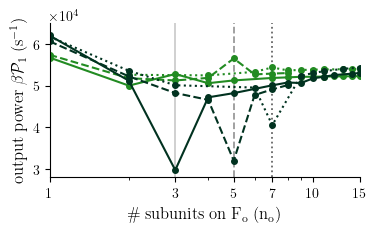

In [31]:
target_array = ["/Users/sarealles/Desktop/Data/Data_processed/pfe/", "/Users/sarealles/Desktop/model1/test_n1_5/pfe/", "/Users/sarealles/Desktop/model1/test_n0_5_vs_n1_7/pfe/"]
n1_array = [3.0,5.0,7.0]
n0_array= [1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0]
Ec_array = [12.0,50.0]


Symmetry_match_plots(target_array, n1_array, n0_array, Ec_array, model="model1", f0=4.0, f1=-2.0, dt=0.001, N=1000, drag=1000)
